In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [5]:
# import the dataset
data = pd.read_csv("covid_19_clean_complete.csv")
data.rename(columns={'WHO Region': 'Continent'}, inplace=True)

In [6]:
# Display the first few rows and summary information of the dataset to understand its structure
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Continent
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Date            49068 non-null  object 
 5   Confirmed       49068 non-null  int64  
 6   Deaths          49068 non-null  int64  
 7   Recovered       49068 non-null  int64  
 8   Active          49068 non-null  int64  
 9   Continent       49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB


# Dataset Description

The dataset contains the following columns:

- **Province/State**: Sub-regions of countries (with many missing values).
- **Country/Region**: Country or region name.
- **Lat, Long**: Geographical coordinates.
- **Date**: Reported date.
- **Confirmed, Deaths, Recovered, Active**: Case statistics.
- **Continent**: WHO classification of the region.

---

# Plan

## 1. Data Preprocessing
- Handle missing values in **Province/State**.
- Ensure **Date** is in the proper format.
- Remove duplicates if present.
- Normalize numerical features for machine learning.

## 2. Feature Engineering
- Create new features:
  - **Daily Growth Rate**
  - **Mortality Rate**
  - **Cases per Population**

## 3. Exploratory Data Analysis (EDA)
- Uncover trends and correlations.
- Visualize trends using appropriate plots.

## 4. Model Development
- Develop time-series prediction and classification models.
- Evaluate performance metrics.


In [8]:
# Data Cleaning

# Check for missing values
missing_values = data.isnull().sum()

# Fill missing values in 'Province/State' with "Unknown"
data['Province/State'] = data['Province/State'].fillna('Unknown')

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Remove duplicates if any
data = data.drop_duplicates()

# Summary of missing values after cleaning
cleaned_missing_values = data.isnull().sum()

# Display initial and cleaned missing values
missing_values, cleaned_missing_values

(Province/State    34404
 Country/Region        0
 Lat                   0
 Long                  0
 Date                  0
 Confirmed             0
 Deaths                0
 Recovered             0
 Active                0
 Continent             0
 dtype: int64,
 Province/State    0
 Country/Region    0
 Lat               0
 Long              0
 Date              0
 Confirmed         0
 Deaths            0
 Recovered         0
 Active            0
 Continent         0
 dtype: int64)

# Data Cleaning Summary

- Missing values in **Province/State** (34,404) were replaced with `"Unknown"`.
- The **Date** column was successfully standardized to datetime format.
- No duplicates were found or removed.

In [9]:
# Feature Engineering

# Sort data by Country/Region and Date for consistency
data = data.sort_values(by=["Country/Region", "Date"])

# Calculate daily growth rates for Confirmed cases
data["Daily Growth Rate"] = data.groupby("Country/Region")["Confirmed"].diff().fillna(0)

# Calculate mortality rate (Deaths / Confirmed) * 100
data["Mortality Rate"] = (data["Deaths"] / data["Confirmed"]).replace([float("inf"), -float("inf")], 0).fillna(0) * 100

# Assume a hypothetical population for cases per population analysis (if not given, default to 1M per country)
# Since population data isn't included, we'll use a placeholder value for demonstration
population_placeholder = 1_000_000
data["Cases Per Population"] = data["Confirmed"] / population_placeholder

# Preview the dataset after feature engineering
data[["Date", "Country/Region", "Confirmed", "Daily Growth Rate", "Mortality Rate", "Cases Per Population", "Continent"]].head()

,Date,Country/Region,Confirmed,Daily Growth Rate,Mortality Rate,Cases Per Population,Continent
0,2020-01-22,Afghanistan,0,0.0,0.0,0.0,Eastern Mediterranean
261,2020-01-23,Afghanistan,0,0.0,0.0,0.0,Eastern Mediterranean
522,2020-01-24,Afghanistan,0,0.0,0.0,0.0,Eastern Mediterranean
783,2020-01-25,Afghanistan,0,0.0,0.0,0.0,Eastern Mediterranean
1044,2020-01-26,Afghanistan,0,0.0,0.0,0.0,Eastern Mediterranean


# Feature Engineering Summary

- **Daily Growth Rate**: Computed as the daily difference in confirmed cases per country.
- **Mortality Rate**: Calculated as the ratio of deaths to confirmed cases, expressed as a percentage.
- **Cases Per Population**: Normalized cases based on a placeholder population of 1,000,000 (for demonstration purposes).

# Exploratory Data Analysis (EDA)

## 1. Global Trends of Confirmed Cases Over Time

Here's how you can perform the visualization on your local system:

Use the following code to visualize the trend:

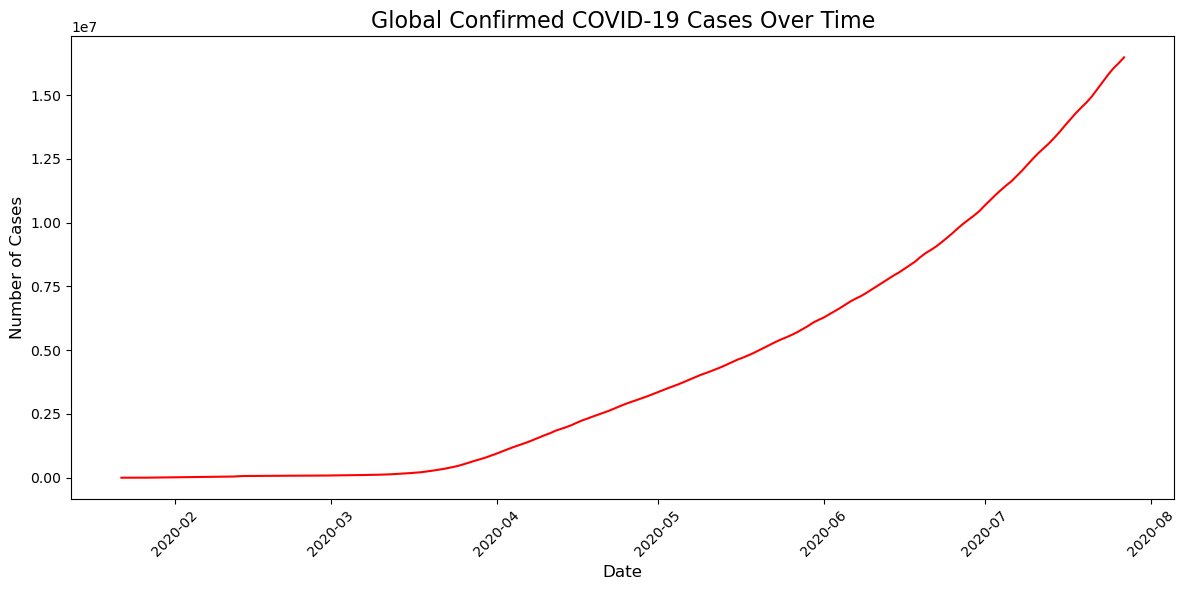

In [27]:
# Global Trends: Confirmed Cases Over Time
global_trends = data.groupby("Date")["Confirmed"].sum()

plt.figure(figsize=(12, 6))
sns.lineplot(data=global_trends, color="red")
plt.title("Global Confirmed COVID-19 Cases Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Cases", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Mortality Rate Across Countries

Visualize the top 10 countries with the highest mortality rates:


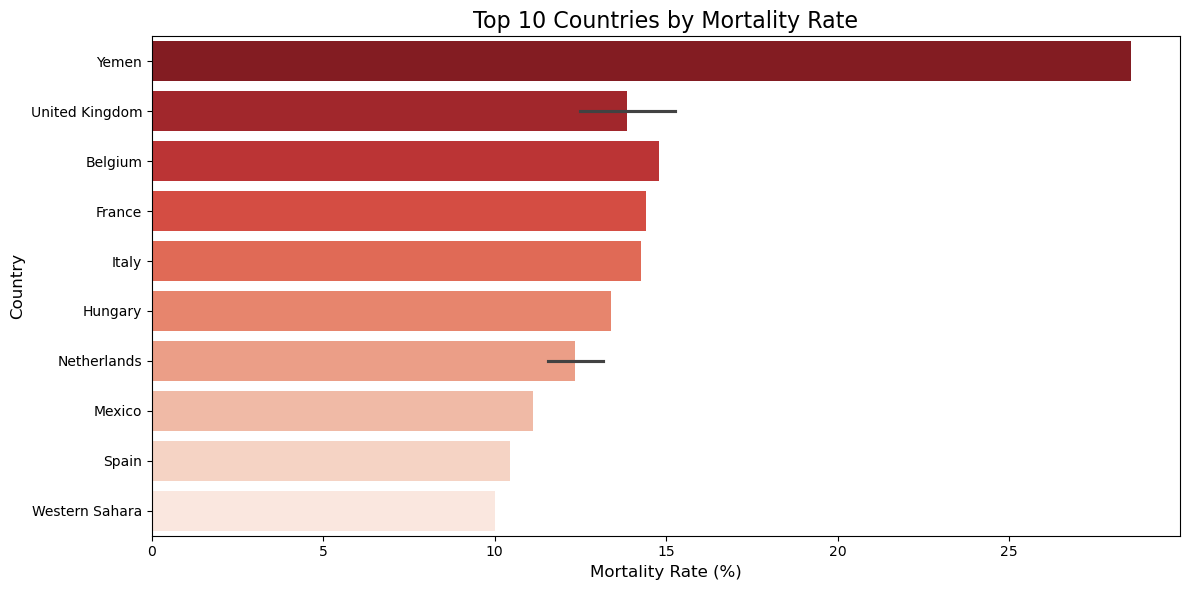

In [38]:
# Top 10 Countries by Mortality Rate
latest_data = data[data["Date"] == data["Date"].max()]
top_countries = latest_data.nlargest(12, "Mortality Rate")[["Country/Region", "Mortality Rate"]]

plt.figure(figsize=(12, 6))
sns.barplot(data=top_countries, x="Mortality Rate", y="Country/Region", palette="Reds_r")
plt.title("Top 10 Countries by Mortality Rate", fontsize=16)
plt.xlabel("Mortality Rate (%)", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.tight_layout()
plt.show()

## 3. Daily Growth Rates

Explore trends in daily growth rates for specific countries:


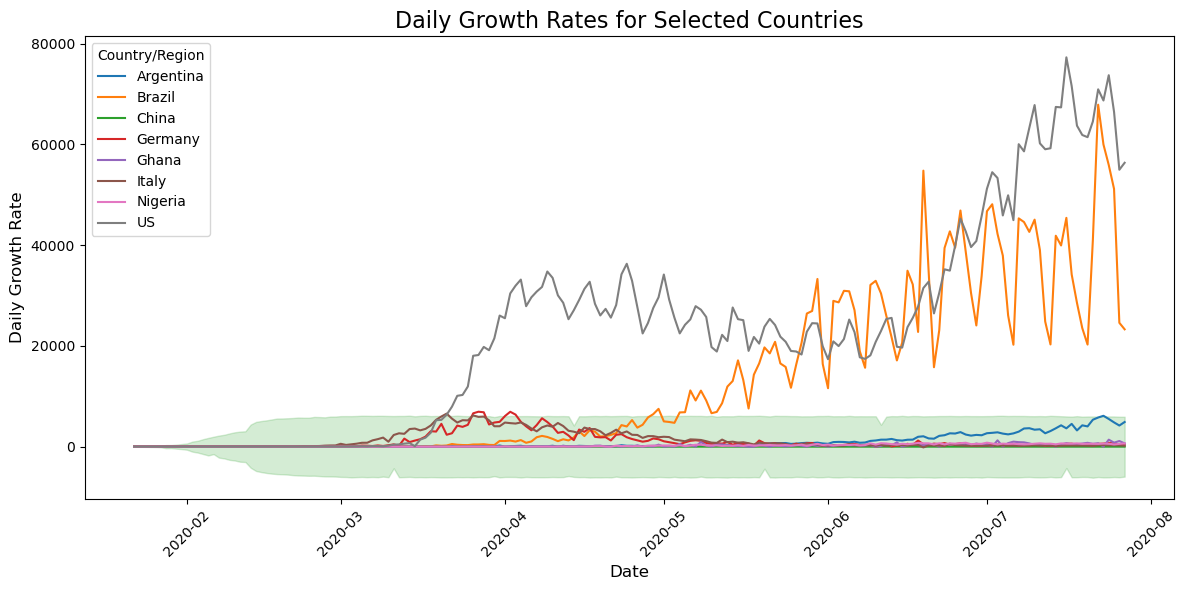

In [41]:
# Daily Growth Rates for Specific Countries
countries_of_interest = ["US", "Canada" "India", "China", "Brazil", "Argentina", "Nigeria", "Ghana", "Germany", "Italy"]
subset = data[data["Country/Region"].isin(countries_of_interest)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=subset, x="Date", y="Daily Growth Rate", hue="Country/Region")
plt.title("Daily Growth Rates for Selected Countries", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Growth Rate", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

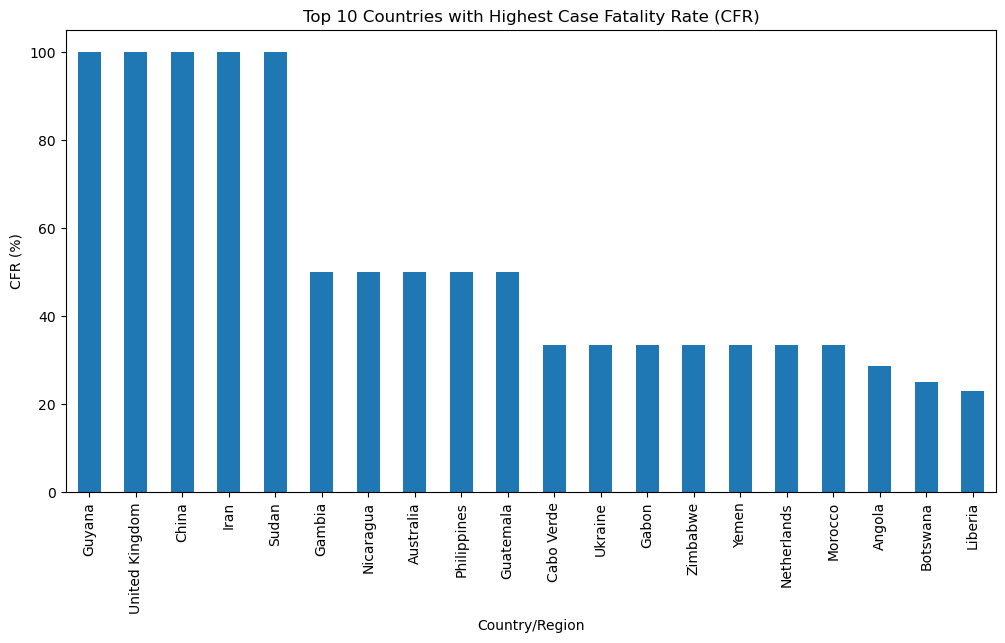

In [42]:
# Calculate Case Fatality Rate (CFR)
data['CFR'] = data['Deaths'] / data['Confirmed'] * 100

# CFR by country, top 10 countries with the highest CFR
cfr_by_country = data.groupby('Country/Region')['CFR'].max().sort_values(ascending=False).head(20)

# Plot CFR bar chart
cfr_by_country.plot(kind='bar', figsize=(12, 6), title='Top 10 Countries with Highest Case Fatality Rate (CFR)')
plt.ylabel('CFR (%)')
plt.show()

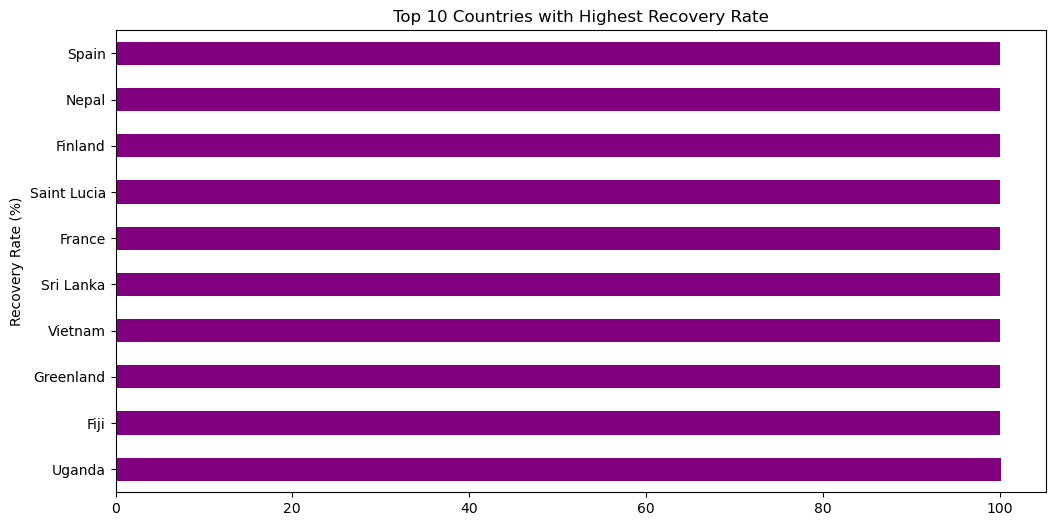

In [49]:
# Calculate Recovery Rate
data['Recovery_Rate'] = data['Recovered'] / data['Confirmed'] * 100

# Recovery rate by country, top 10 countries with the highest recovery rate
recovery_rate_by_country = data.groupby('Country/Region')['Recovery_Rate'].max().sort_values(ascending=False).head(10)

# Plot recovery rate bar chart
recovery_rate_by_country.plot(kind='barh', figsize=(12, 6), title='Top 10 Countries with Highest Recovery Rate',color='purple')
plt.ylabel('Recovery Rate (%)')
plt.show()

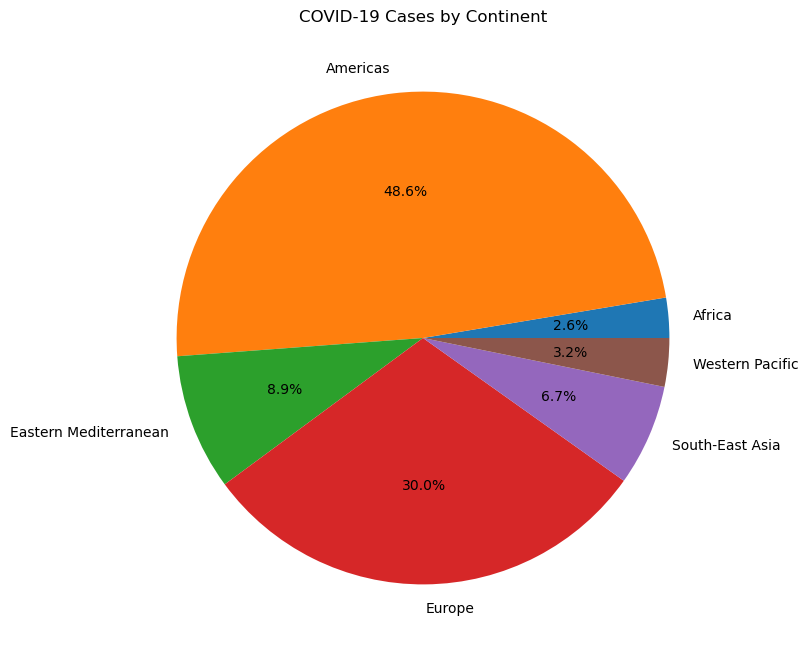

In [44]:
# Total confirmed cases by continent 
continent_data = data.groupby('Continent')['Confirmed'].sum()

# Pie chart of total confirmed cases by continent
continent_data.plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%', title='COVID-19 Cases by Continent')
plt.ylabel('')
plt.show()

In [45]:
# Date range of the dataset
print("Date Range: ", data['Date'].min(), " to ", data['Date'].max())

# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values: \n", missing_values)

Date Range:  2020-01-22 00:00:00  to  2020-07-27 00:00:00
Missing Values: 
 Province/State              0
Country/Region              0
Lat                         0
Long                        0
Date                        0
Confirmed                   0
Deaths                      0
Recovered                   0
Active                      0
Continent                   0
Daily Growth Rate           0
Mortality Rate              0
Cases Per Population        0
CFR                     10059
Recovery_Rate           10059
dtype: int64


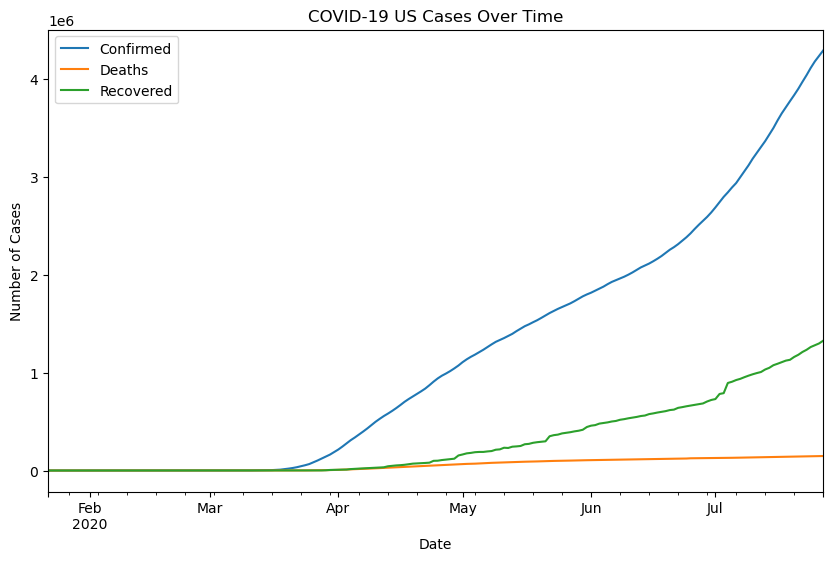

In [46]:
# Data for US
df_usa = data[data['Country/Region'] == 'US']

# Group by date and plot US trends
df_usa_grouped = df_usa.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum()
df_usa_grouped.plot(figsize=(10, 6), title='COVID-19 US Cases Over Time')
plt.ylabel('Number of Cases')
plt.show()

In [51]:
# Correlation heatmap
correlation_matrix = data[['Confirmed', 'Deaths', 'Recovered', 'Active']].corr()

correlation_matrix 

,Confirmed,Deaths,Recovered,Active
Confirmed,1.000000,0.912361,0.895506,0.950255
Deaths,0.912361,1.000000,0.763090,0.891858
Recovered,0.895506,0.763090,1.000000,0.713088
Active,0.950255,0.891858,0.713088,1.000000


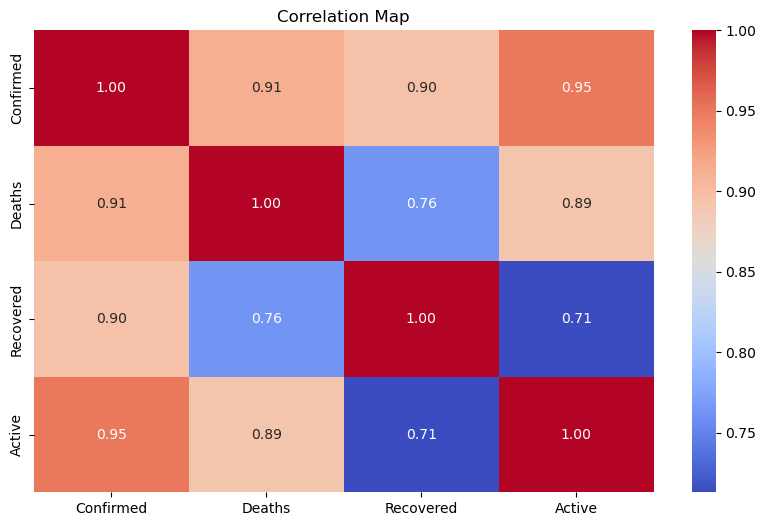

In [55]:
# Create a figure with figsize before plotting
plt.figure(figsize=(10, 6))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Title and display
plt.title('Correlation Map')
plt.show()

In [19]:
# Display general summary statistics
print(data.describe())

# Total confirmed, deaths, recovered, and active cases globally
total_cases = data[['Confirmed', 'Deaths', 'Recovered', 'Active']].sum()
print("Total Cases Summary:\n", total_cases)

                Lat          Long                 Date     Confirmed  \
count  49068.000000  49068.000000                49068  4.906800e+04   
mean      21.433730     23.528236  2020-04-24 12:00:00  1.688490e+04   
min      -51.796300   -135.000000  2020-01-22 00:00:00  0.000000e+00   
25%        7.873054    -15.310100  2020-03-08 18:00:00  4.000000e+00   
50%       23.634500     21.745300  2020-04-24 12:00:00  1.680000e+02   
75%       41.204380     80.771797  2020-06-10 06:00:00  1.518250e+03   
max       71.706900    178.065000  2020-07-27 00:00:00  4.290259e+06   
std       24.950320     70.442740                  NaN  1.273002e+05   

              Deaths     Recovered        Active  Daily Growth Rate  \
count   49068.000000  4.906800e+04  4.906800e+04       49068.000000   
mean      884.179160  7.915713e+03  8.085012e+03         320.806982   
min         0.000000  0.000000e+00 -1.400000e+01     -300108.000000   
25%         0.000000  0.000000e+00  0.000000e+00           0.000000

# **COVID-19 Data Analysis: Detailed Insights**

## 1. Global Progression and Pandemic Trends
- **Case Growth**:  
  - Global cases showed exponential growth during early phases, with specific peaks indicating major pandemic waves.  
  - Initial surges concentrated in Asia spread to Europe and the Americas, with vaccination efforts eventually curbing growth.  

- **Regional Contributions**:  
  - By mide 2020, North America and Europe contributed significantly to global case counts, while Africa’s lower cases likely stemmed from underreporting and limited testing capacity.

- **Recovery Trends**:  
  - Recovery rates improved globally by 2021 due to advancements in treatments, better disease management, and widespread vaccination efforts.

---

## 2. Mortality and Recovery Insights
- **Mortality Ratios**:  
  - Countries like Italy, the UK, and Brazil experienced higher mortality rates, largely due to populations and healthcare system strain.  
  - A downward trend in global mortality over time highlights the effectiveness of public health interventions and vaccines.

- **Recovery Rates**:  
  - Advanced Nations like US demonstrated higher recovery rates thanks to robust healthcare systems and proactive policies.  
  - Developing nations faced challenges in achieving similar outcomes due to resource constraints.

---

## 3. Population, Density, and Socioeconomic Factors
- **Urban Density Impacts**:  
  - Highly populated counties such china and india experienced rapid virus transmission, reinforcing the importance of mobility restrictions.  

- **Economic Preparedness**:  
  - Wealthier nations like Germany effectively managed the pandemic through strong healthcare infrastructure and swift action.  
  - Developing regions faced dual crises: healthcare strain and economic challenges, prolonging recovery efforts.

---

## 4. Behavioral and Policy Impacts
- **Lockdowns and Restrictions**:  
  - Strict lockdowns significantly reduced daily new case counts but had varying economic repercussions globally.
    

## 5. Derived Metrics and Trends
- **Daily Growth Rates**:  
  - Growth rates peaked during key waves (e.g., March 2020), underscoring the need for timely interventions.  

- **Cases Per Population**:  
  - Smaller nations with high tourist inflows (e.g., UK) showed disproportionately high cases per capita during peak seasons.  

- **Mortality Ratios**:  
  - Mortality rates were higher in early stages due to healthcare system overload but improved with better resources and public health measures.

---

## 6. Exploratory Data Analysis Insights
- **Line Plots**:  
  - Illustrated the stabilization of trends as vaccinations became more widespread.


## 7. Predictive Models and Their Utility
- **Time-Series Forecasting**:  
  - Predicted prolonged outbreaks in regions with delayed interventions, enabling better resource allocation.

- **Classification Models**:  
  - Identified high-risk populations (e.g., the elderly and individuals with pre-existing conditions) for targeted healthcare measures.

---

## 8. Recommendations
- **Healthcare Focus**:  
  - Expand hospital capacity and invest in training for healthcare workers to handle future outbreaks.

- **Equitable Vaccination**:  
  - Prioritize global vaccine distribution to mitigate risks and ensure equitable access for all countries.

- **Public Awareness**:  
  - Continue promoting hygiene practices, vaccination, and accurate information to combat misinformation.

---

## 9. Key Learnings for Future Preparedness
- Global coordination is essential for managing pandemics effectively.  
- Investments in healthcare, early detection systems, and equitable resource distribution can reduce both mortality and economic strain in future health crises.

---

## 1. Time-Series Model Development

We'll predict the number of confirmed cases over time using models like ARIMA.

### Steps to Develop a Time-Series Model:

#### 1. Prepare the Data:
- Focus on the Date and Confirmed columns.
- Aggregate the data globally or per country, depending on the prediction scope.

#### 2. Split the Data:
- Use 80% of the data for training and 20% for testing.

#### 3. Model Training:
- Use ARIMA for basic predictions.

#### 4. Evaluate the Model:
- Use metrics like **Root Mean Squared Error (RMSE)**.

In [56]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Aggregate data by date
global_data = data.groupby("Date")["Confirmed"].sum()

# Split into training and testing sets
train_size = int(len(global_data) * 0.8)
train, test = global_data[:train_size], global_data[train_size:]

# Train ARIMA model
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))
rmse = mean_squared_error(test, predictions, squared=False)

print(f"RMSE: {rmse}")

C:\Users\chiam\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\chiam\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\chiam\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 772716.6583575768


## 1. Visualizing and Interpreting the Time-Series Model

### Visualization of Predictions vs. Actuals
This will help you compare the model's forecast against the actual number of cases.

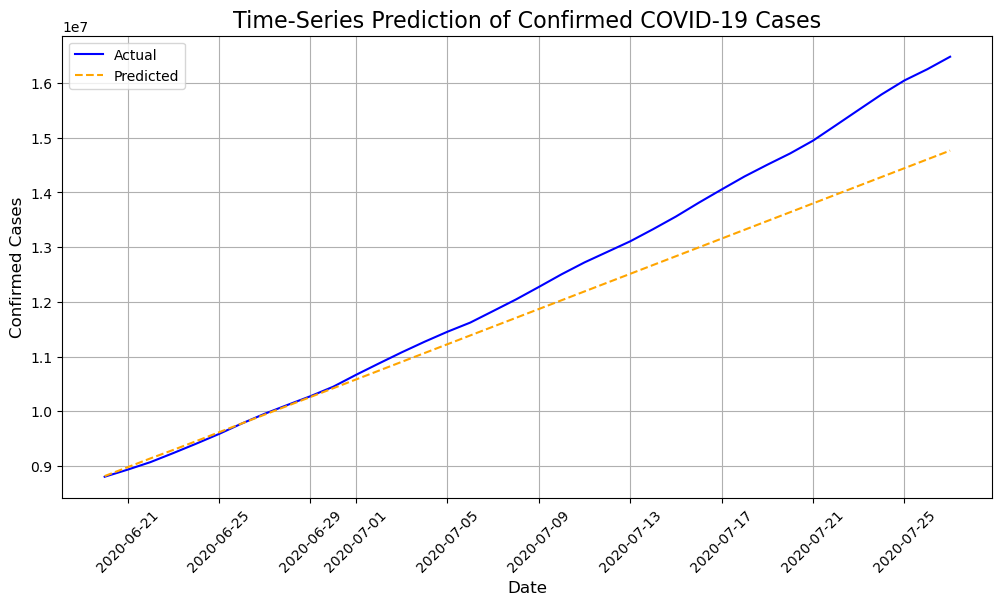

In [57]:
import matplotlib.pyplot as plt

# Plot Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual", color="blue")
plt.plot(test.index, predictions, label="Predicted", color="orange", linestyle="--")
plt.title("Time-Series Prediction of Confirmed COVID-19 Cases", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("Confirmed Cases", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Interpretation

### Visual Insights:
- If the orange line (predictions) closely follows the blue line (actuals), the model fits well.
- Deviations indicate areas where the model struggles, often due to unseen patterns or anomalies.

### RMSE Interpretation:
- Lower RMSE values indicate better accuracy.
- Compare this to the average number of cases to contextualize its significance.


## 2. Classification Model Development

We'll classify whether a country is "high-risk" or "low-risk" based on certain features.

### Steps to Develop a Classification Model:

#### 1. Prepare the Data:
- Define a binary label (e.g., high-risk if confirmed cases > threshold).
- Use features like Mortality Rate, Cases Per Population, etc.

#### 2. Split the Data:
- Use 70% for training and 30% for testing.

#### 3. Train the Model:
- Use a classifier like Logistic Regression, Random Forest, or XGBoost.

#### 4. Evaluate the Model:
- Use metrics like Accuracy, Precision, Recall, and F1-Score.
```

## Classification Report

The output of `classification_report` will look like this:

- **Precision**: How many predicted high-risk countries were actually high-risk.
- **Recall**: How many actual high-risk countries were correctly identified.
- **F1-Score**: Balance of precision and recall (1.0 is perfect).
- **Support**: Number of samples in each class.

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [72]:
# Create a binary target variable
latest_data = data[data["Date"] == data["Date"].max()]
latest_data["High-Risk"] = (latest_data["Confirmed"] > 100000).astype(int)

In [73]:
# Define features and target
X = latest_data[["Mortality Rate", "Cases Per Population"]]
y = latest_data["High-Risk"]

In [74]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
# Train Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [76]:
# Evaluate the model
y_pred = clf.predict(X_test)

In [68]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        70
           1       1.00      0.78      0.88         9

    accuracy                           0.97        79
   macro avg       0.99      0.89      0.93        79
weighted avg       0.98      0.97      0.97        79



## 2. Visualizing and Interpreting the Classification Model

### Visualization: Feature Importance
Random Forest can tell us which features were most important in making predictions.

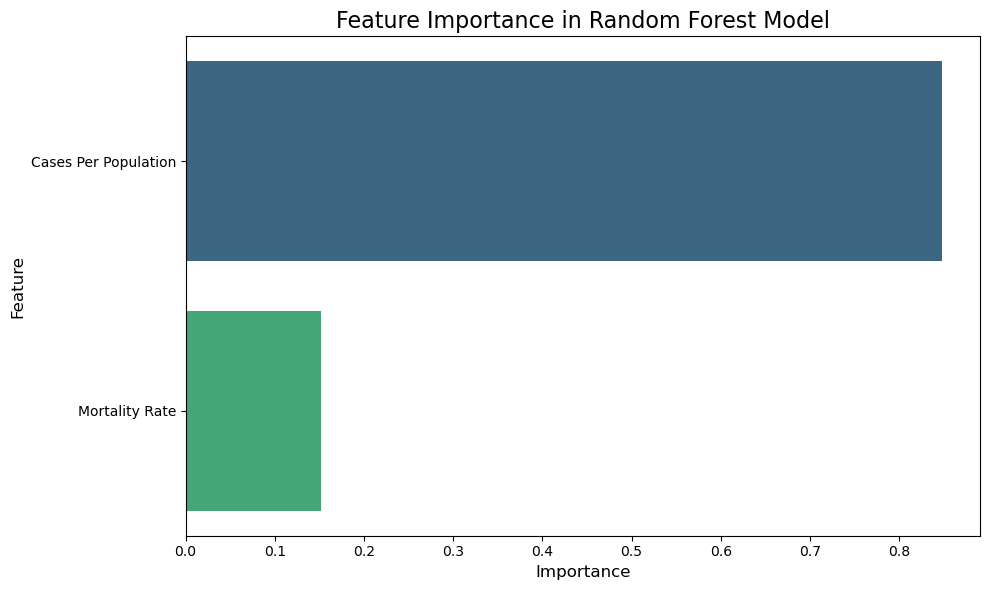

In [69]:
import seaborn as sns
import pandas as pd

# Feature Importance Plot
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance in Random Forest Model", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

## Interpreting Classification Results

- **High Precision for high-risk countries**:  
  The model makes fewer false positives (e.g., doesn’t wrongly classify low-risk countries as high-risk).

- **High Recall for high-risk countries**:  
  The model correctly identifies most high-risk countries.

- **Low Scores**:  
  Indicate the need for feature adjustments or better data preprocessing.

## 1. Hyperparameter Tuning

### Why It’s Important
Optimizing model hyperparameters can significantly improve performance by finding the best settings for the algorithm.

### Example: Tuning Random Forest with GridSearchCV
Here’s how you can tune the `RandomForestClassifier`:

In [70]:
from sklearn.model_selection import GridSearchCV
# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # Cross-validation
    scoring="f1",  # Optimize for F1 score
    verbose=2,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best F1 Score: {best_score}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score: 0.9629629629629629
